# Lab: Data Processing and Summarization

This Cagatay's code helps you go through different functions in data processing and summarization

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.spatial.distance import cdist # This is the function that computes the Mahalanobis distance
from scipy.stats import skew, kurtosis # The skew and kurtosis of a distribution
from statsmodels.robust.scale import mad # This computes the median absolute deviation of a distribution
import matplotlib.pyplot as plt
%matplotlib inline

## Outliers

1) Load the data on properties of cars into a pd dataframe

In [2]:
# Loading Data
df = pd.read_csv('data/raw/accord_sedan.csv')

# Inspecting the few first rows of the dataframe
df.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


2) Visualise the columns: "price" and "mileage"

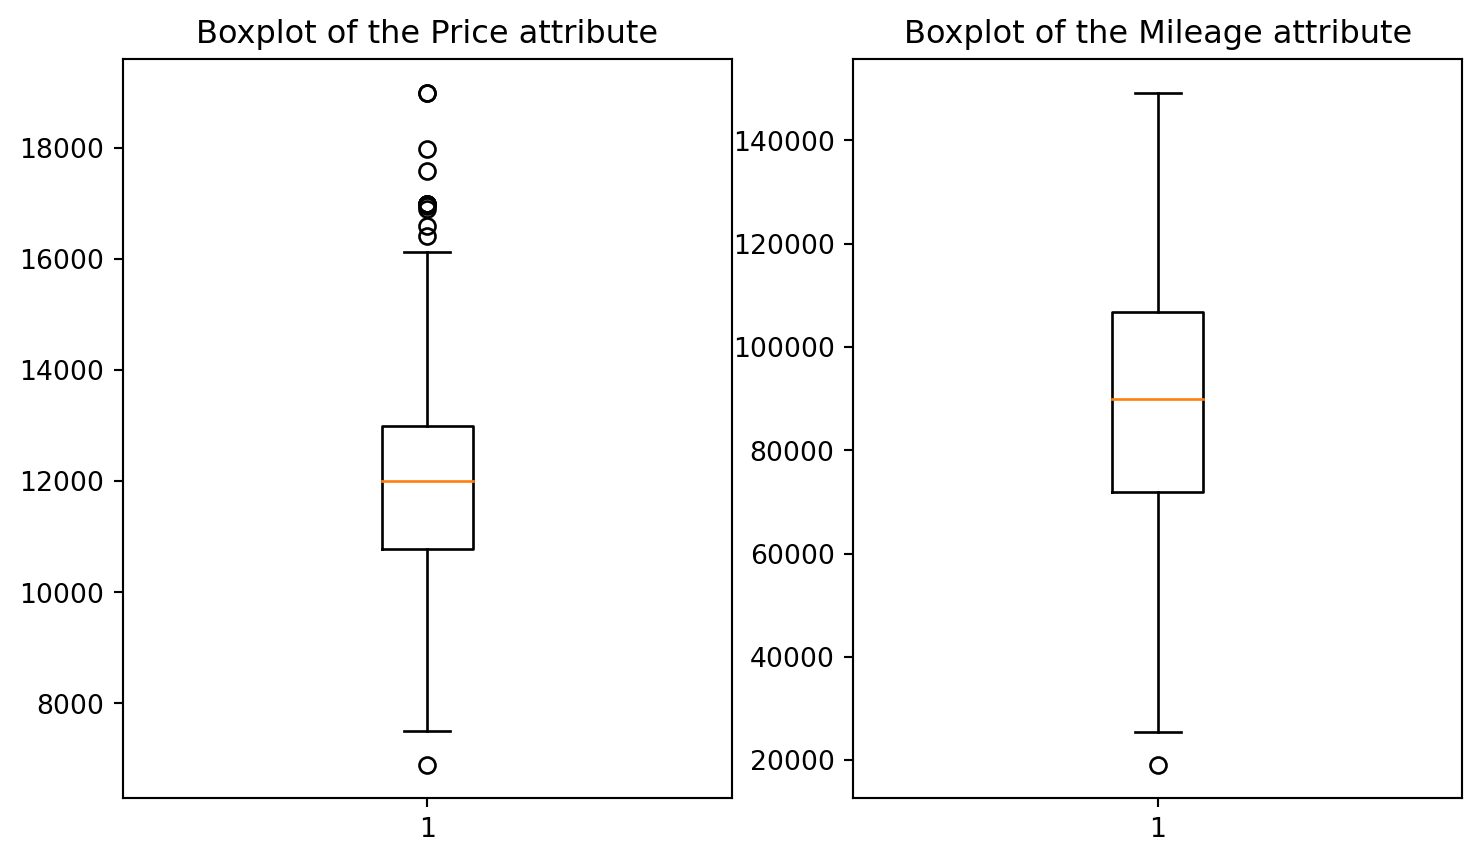

In [3]:

# 1D Visualizations
plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
plt.boxplot(df.price)
plt.title("Boxplot of the Price attribute")
plt.subplot(1,2,2)
plt.boxplot(df.mileage)
plt.title("Boxplot of the Mileage attribute");

# A semicolon in Python denotes separation, rather than termination. 
# It allows you to write multiple statements on the same line. 

1) Identify the 2D outliers using the visualisation

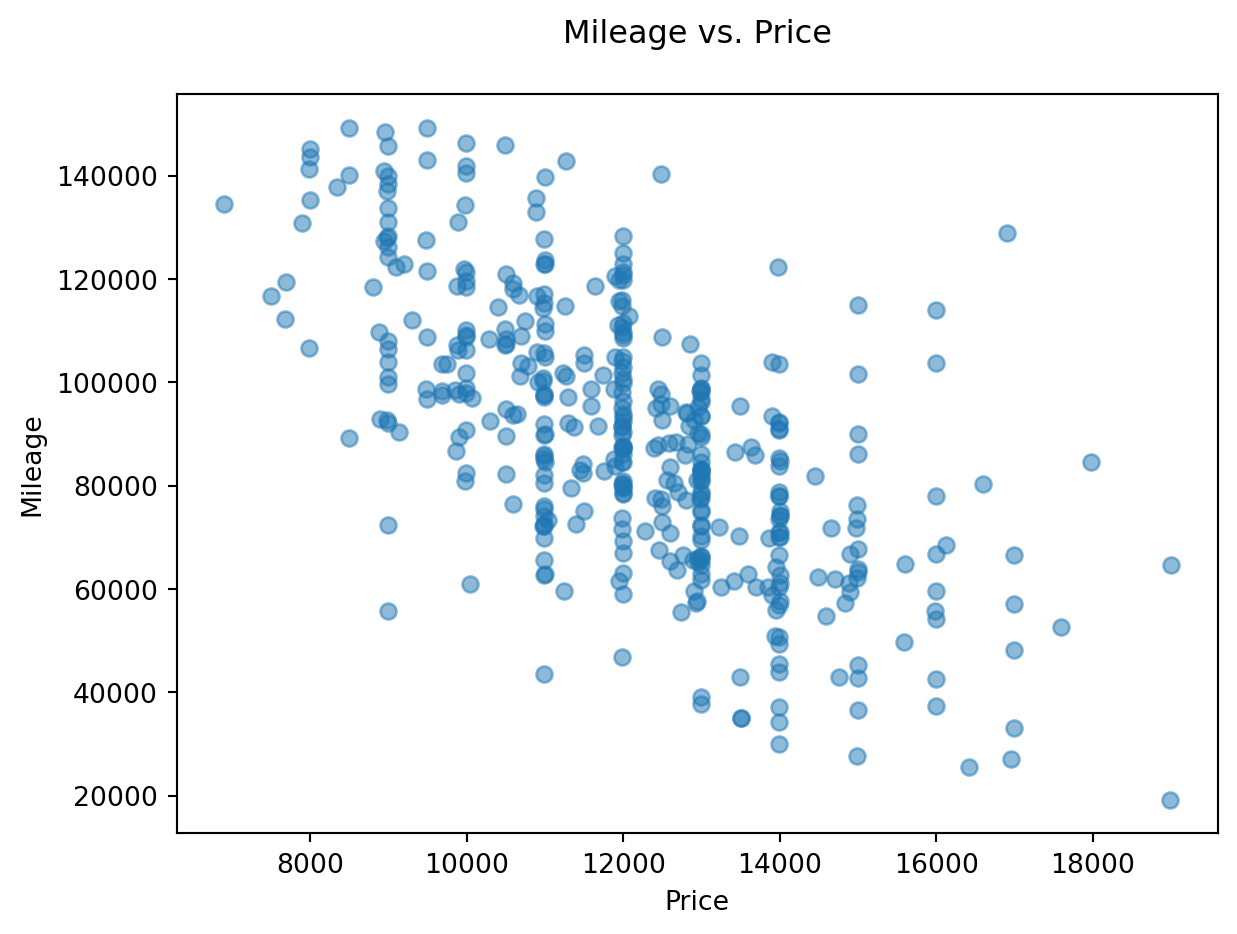

In [4]:
# 2D Visualization
plt.scatter(df.price, df.mileage, alpha = .5)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.title('Mileage vs. Price\n');

<p>
    Visually, outliers appear to be outside the 'normal' range of the rest of the points. A few outliers are quite obvious to spot, but the choice of the threshold (the limit after which you decide to label a point as an outlier) visually remains a very subjective matter.
</p>

<b>4) Add two new columns to the dataframe called `isOutlierPrice` and `isOutlierMileage`. For the price column, calculate the mean and standard deviation. Find any rows that are more than 2 times standard deviations away from the mean and mark them with a 1 in the isOutlierPrice column. Do the same for mileage column</b>

In [5]:
# Computing the isOutlierPrice column
upper_threshold_price = df.price.mean() + 2*df.price.std()
lower_threshold_price = df.price.mean() - 2*df.price.std()
df['isOutlierPrice'] = ((df.price > upper_threshold_price) | (df.price < lower_threshold_price))

# Computing the isOutlierMileage column
upper_threshold_mileage = df.mileage.mean() + 2*df.mileage.std()
lower_threshold_mileage = df.mileage.mean() - 2*df.mileage.std()
df['isOutlierMileage'] = ((df.mileage > upper_threshold_mileage) | (df.mileage < lower_threshold_mileage))

# Second way of doing the above using the np.where() function
#df['isOutlierPrice'] = np.where(abs(df.price - df.price.mean()) < 2*df.price.std(), False, True)
#df['isOutlierMileage'] = np.where(abs(df.mileage - df.price.mileage()) < 2*df.mileage.std(), False, True)

# Inspect the new DataFrame with the added columns
df.head()

,price,mileage,year,trim,engine,transmission,isOutlierPrice,isOutlierMileage
0,14995,67697,2006,ex,4 Cyl,Manual,False,False
1,11988,73738,2006,ex,4 Cyl,Manual,False,False
2,11999,80313,2006,lx,4 Cyl,Automatic,False,False
3,12995,86096,2006,lx,4 Cyl,Automatic,False,False
4,11333,79607,2006,lx,4 Cyl,Automatic,False,False


1) Visualize these values with a different color in the plot. Observe whether they are the same as you would mark them

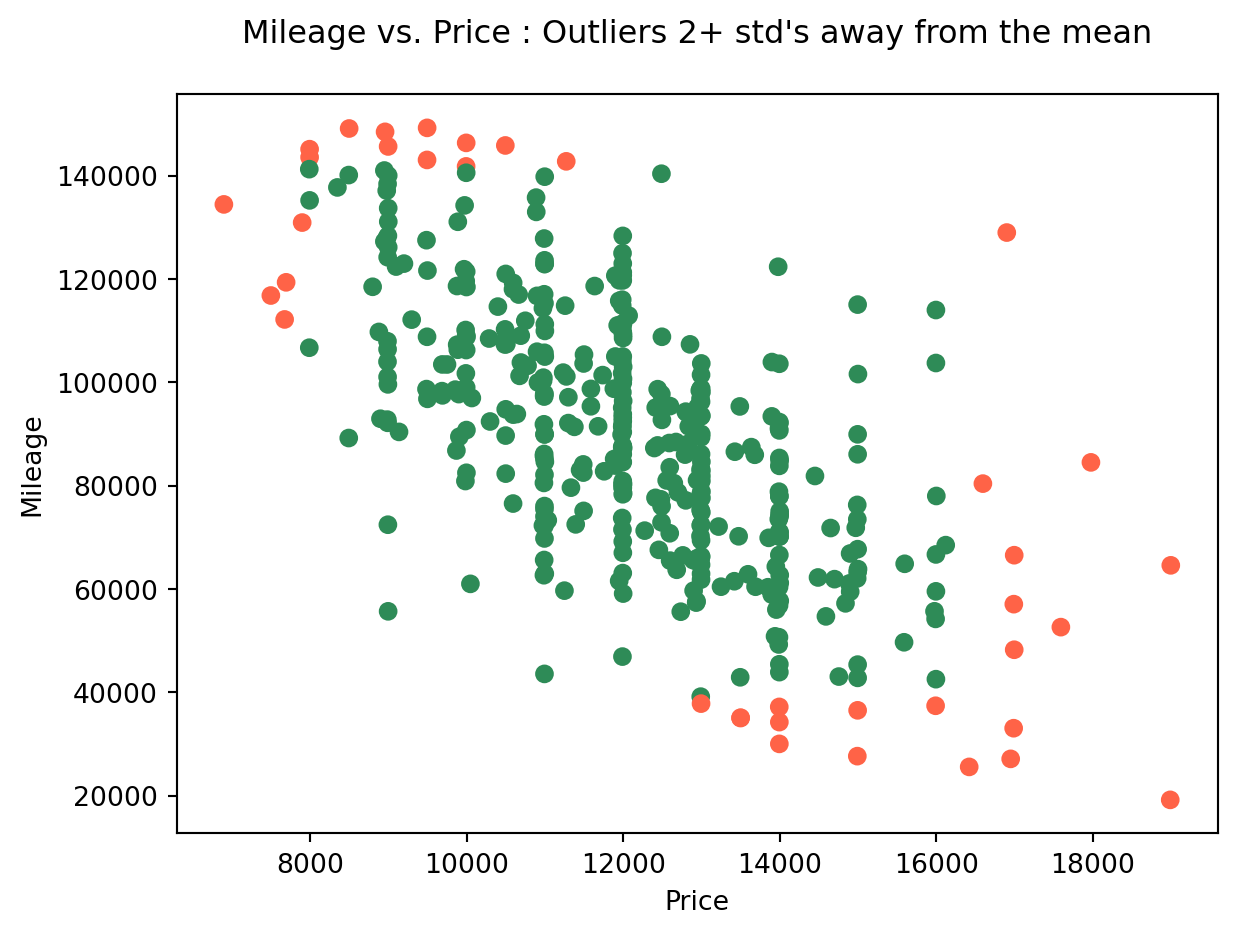

In [6]:
# Visualizing outliers in a different color
col = ['tomato' if i+j else 'seagreen' for i,j in zip(df.isOutlierPrice, df.isOutlierMileage)]
plt.scatter(df.price, df.mileage, color = col)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.title('Mileage vs. Price : Outliers 2+ std\'s away from the mean\n');

<p>
    Visually filtering out outliers can be an effective tactic if we're just trying to conduct a quick and dirty experimentation. However, when we need to perform a solid and founded analysis, it's better to have a robust justification for our choices. In this case, we can use the deviation from the mean to define a threshold that separates 'normal' values from 'outliers'. Here, we opted for a two standard deviation threshold. The mathematical intuition behind this, is that under the normality assumption (if we assume our variable is normally distributed, which it almost is, refer to the next plot), then the probability of it having a value two standard deviations OR MORE away from the mean, is around 5%, which is very unlikely to happen. This is why we label these data points as outliers with respect to the (assumed) probability distribution of the variable. But this remains a way to identify 1D outliers only (identifying outliers within each column separately)
</p>

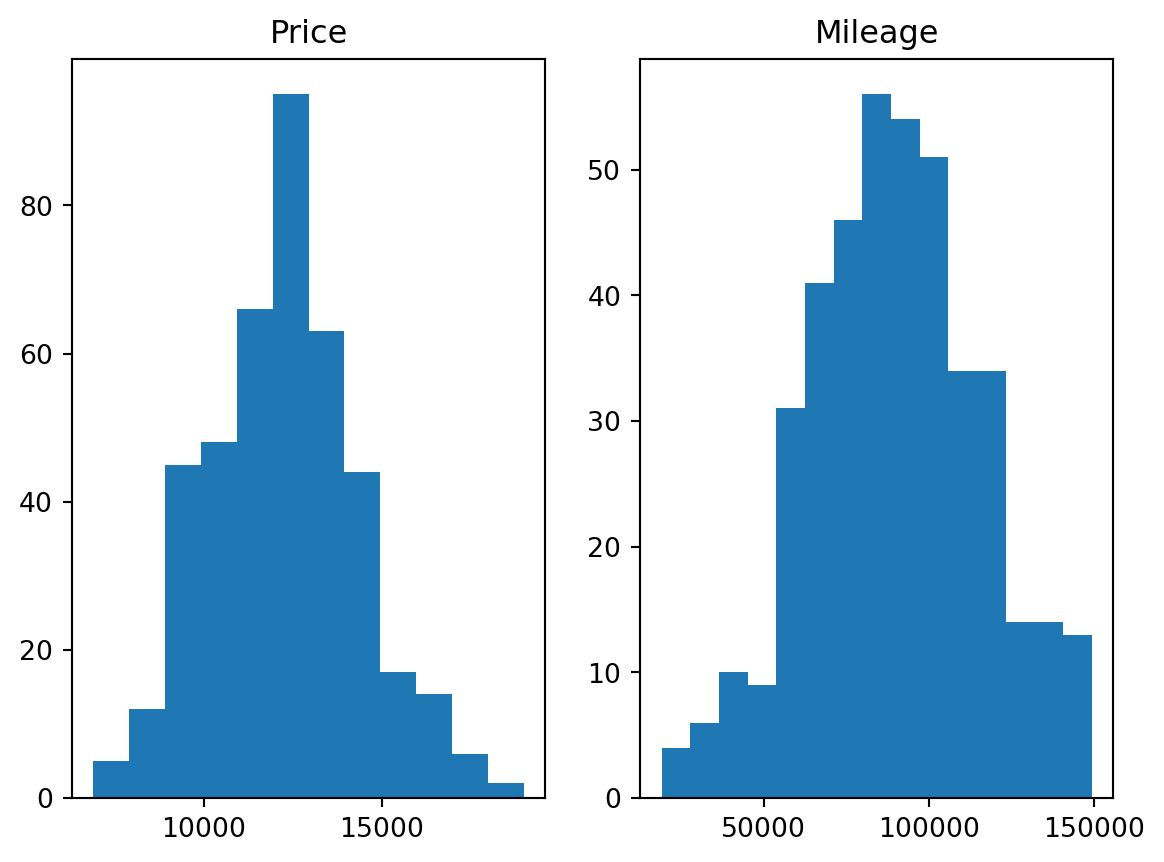

In [7]:
# Histograms of Price and Mileage (checking the normality assumption)
plt.subplot(1,2,1)
plt.hist(df.price, bins = 12)
plt.title('Price')
plt.subplot(1,2,2)
plt.hist(df.mileage, bins = 15)
plt.title('Mileage');

1) Using the 2D Mahalanobis distance to find outliers

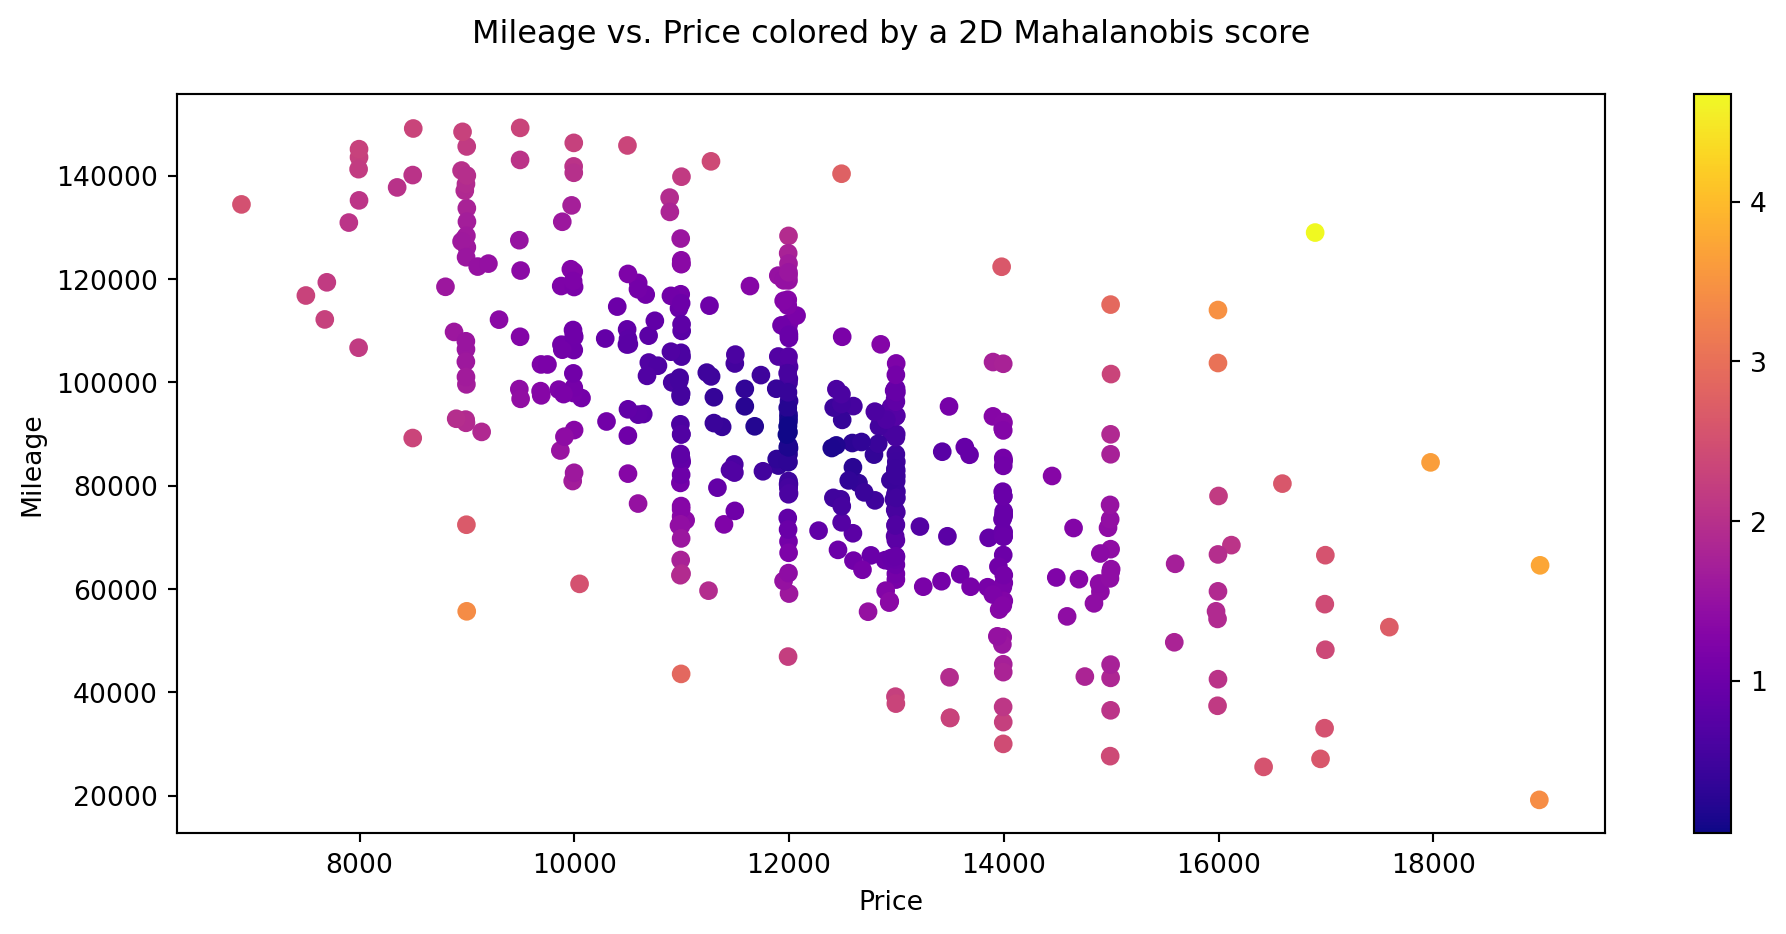

In [8]:
#| column: page-inset-right

# Mean vector (computing the mean returns a Series, which we need to convert back to a DataFrame because cdist requires it)
mean_v = df.iloc[:, 0:2].mean().to_frame().T # DataFrame.T returns the Transpose of the DataFrame
#mean_v = np.asarray([df.price.mean(), df.mileage.mean() ]).reshape(1,2) # This is a better way of writing the line before (for our use case : cdist function)

# Computing the Mahalanobis distance of each row to the mean vector
d = cdist(df.iloc[:, 0:2], mean_v, metric='mahalanobis')
#d = cdist(df[['price', 'mileage']].values, mean_v, metric='mahalanobis') # Another way of writing the line before

# Visualizing the scatter plot while coloring each point (i.e row) with a color from a chosen gradient colormap corresponding to the mahalanobis score
plt.figure(figsize=(12, 5))
plt.scatter(df.price, df.mileage, c = d.flatten(), cmap = 'plasma') # in order to know why we use flatten() on d, try printing d with and without flatten
plt.colorbar() # to show the colorbar
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.title('Mileage vs. Price colored by a 2D Mahalanobis score\n');

## Q-Q Plots

In [9]:
# Getting the Data in
df_tuber = pd.read_csv('data/raw/TB_burden_countries_2014-09-29.csv')

# Filling missing numeric values (I repeat NUMERIC COLUMNS, I didn't touch categorical ones because we don't need them here)
df_tuber = df_tuber.fillna(value=df_tuber.mean(numeric_only = True))

# Inspecting missing values in dataset
pd.isnull(df_tuber).sum()

country                      0
iso2                        23
iso3                         0
iso_numeric                  0
g_whoregion                  0
year                         0
e_pop_num                    0
e_prev_100k                  0
e_prev_100k_lo               0
e_prev_100k_hi               0
e_prev_num                   0
e_prev_num_lo                0
e_prev_num_hi                0
e_mort_exc_tbhiv_100k        0
e_mort_exc_tbhiv_100k_lo     0
e_mort_exc_tbhiv_100k_hi     0
e_mort_exc_tbhiv_num         0
e_mort_exc_tbhiv_num_lo      0
e_mort_exc_tbhiv_num_hi      0
source_mort                  1
e_inc_100k                   0
e_inc_100k_lo                0
e_inc_100k_hi                0
e_inc_num                    0
e_inc_num_lo                 0
e_inc_num_hi                 0
e_tbhiv_prct                 0
e_tbhiv_prct_lo              0
e_tbhiv_prct_hi              0
e_inc_tbhiv_100k             0
e_inc_tbhiv_100k_lo          0
e_inc_tbhiv_100k_hi          0
e_inc_tb

1) Pick one of the columns from the Tuberculosis data and copy it into a numpy array as before

In [10]:
# Picking a column (I created a variable for this so I (and you (: ) can modify the column easily here and the change will be carried out everywhere I use the variable colname)
colname = 'e_prev_100k'

# Creating a numpy array from our column
col = np.array(df_tuber[colname])

# Printing the type of our newly created column
print(type(col))

<class 'numpy.ndarray'>


1) Compare this selected column to a Normal distribution. Then Sample from a Normal distribution and show a second Q-Q plot

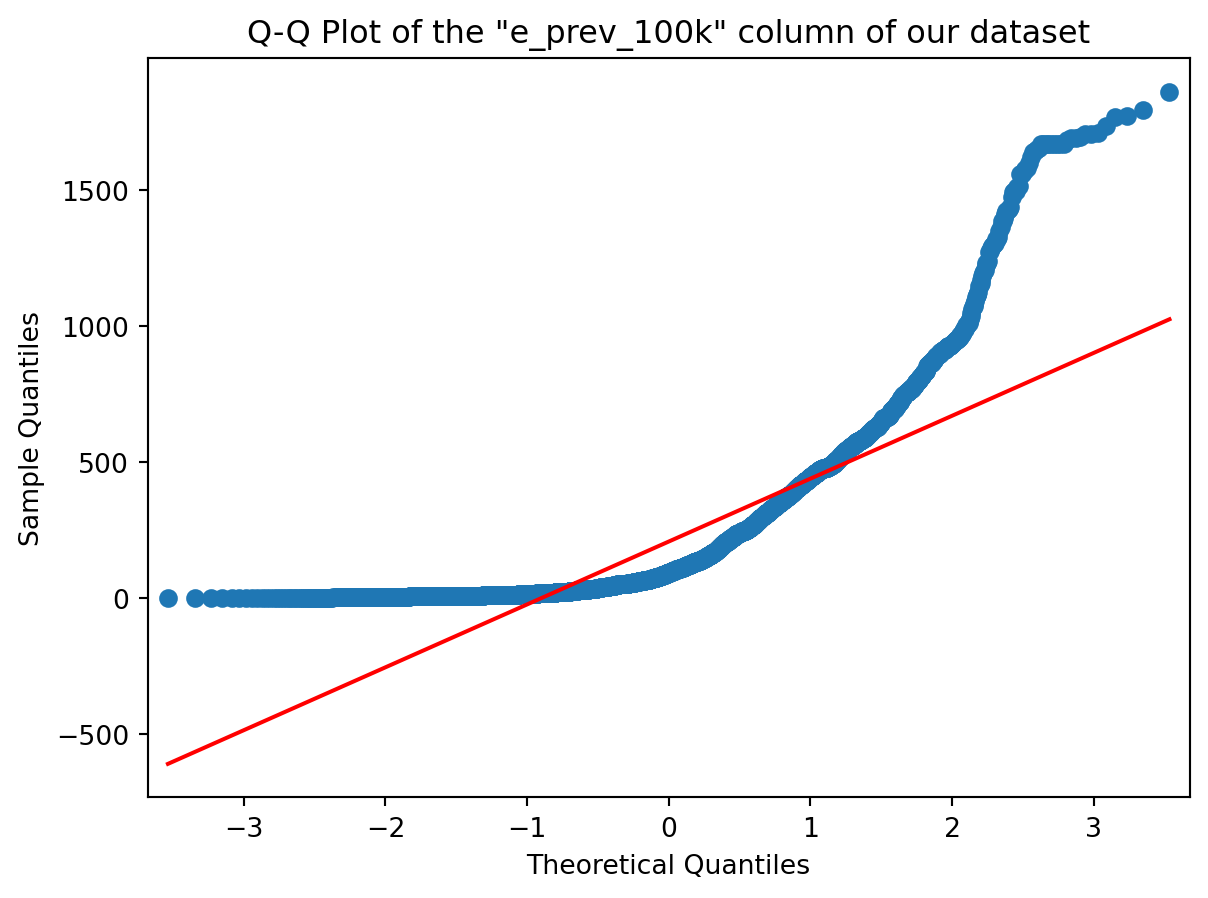

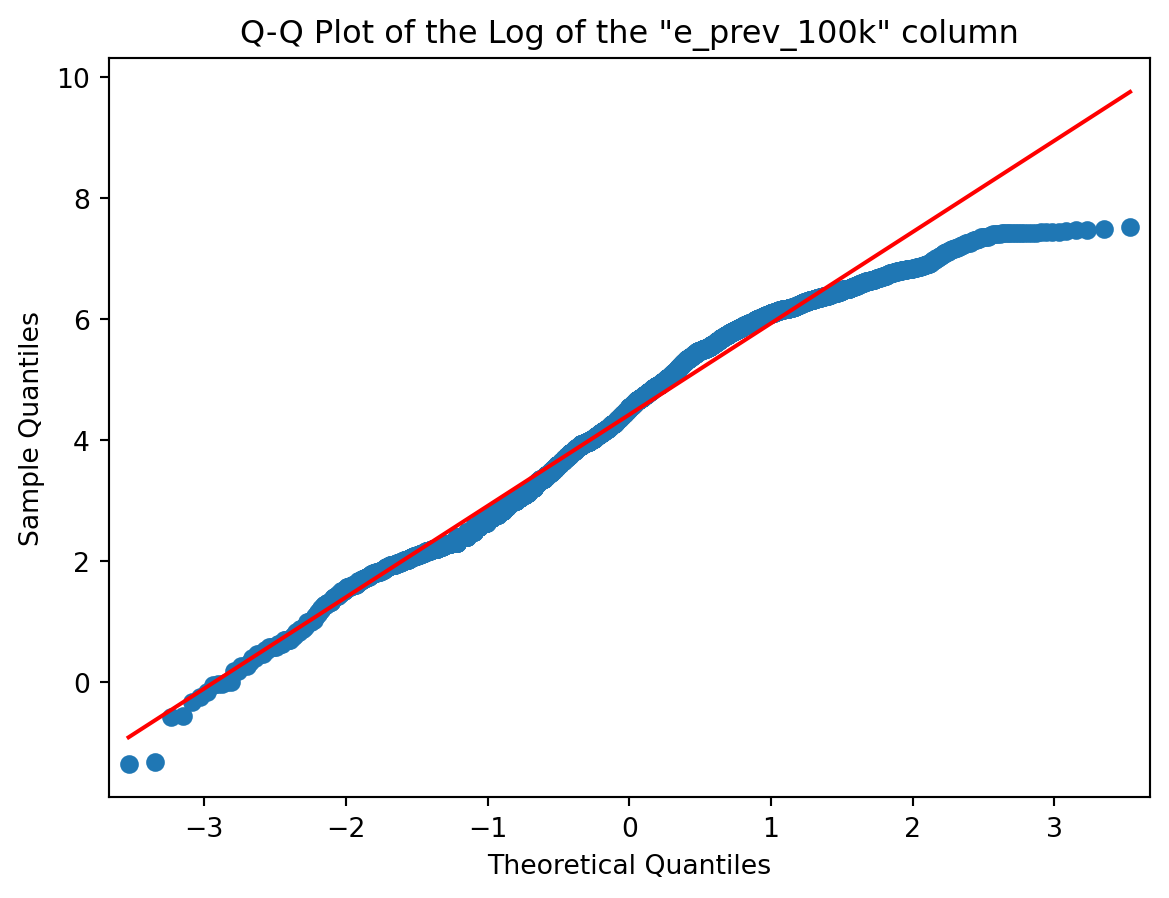

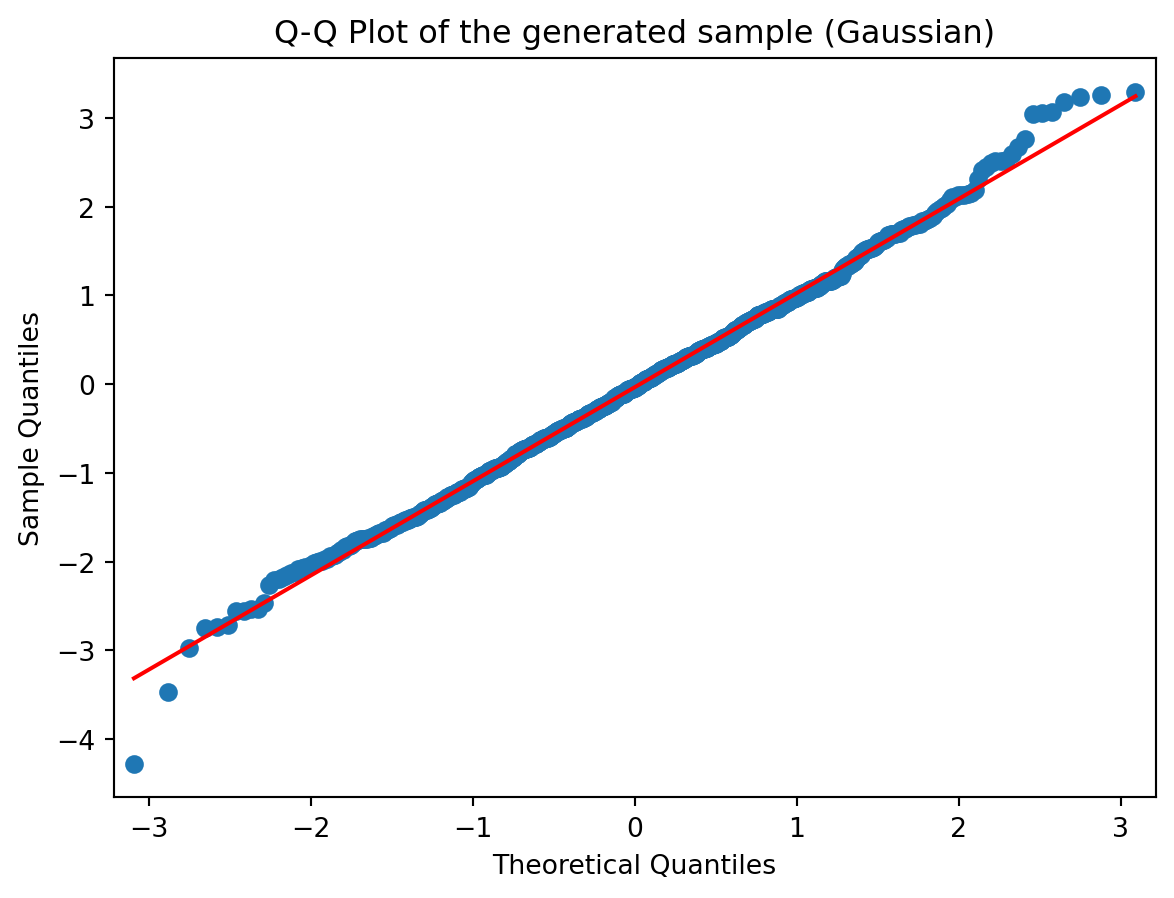

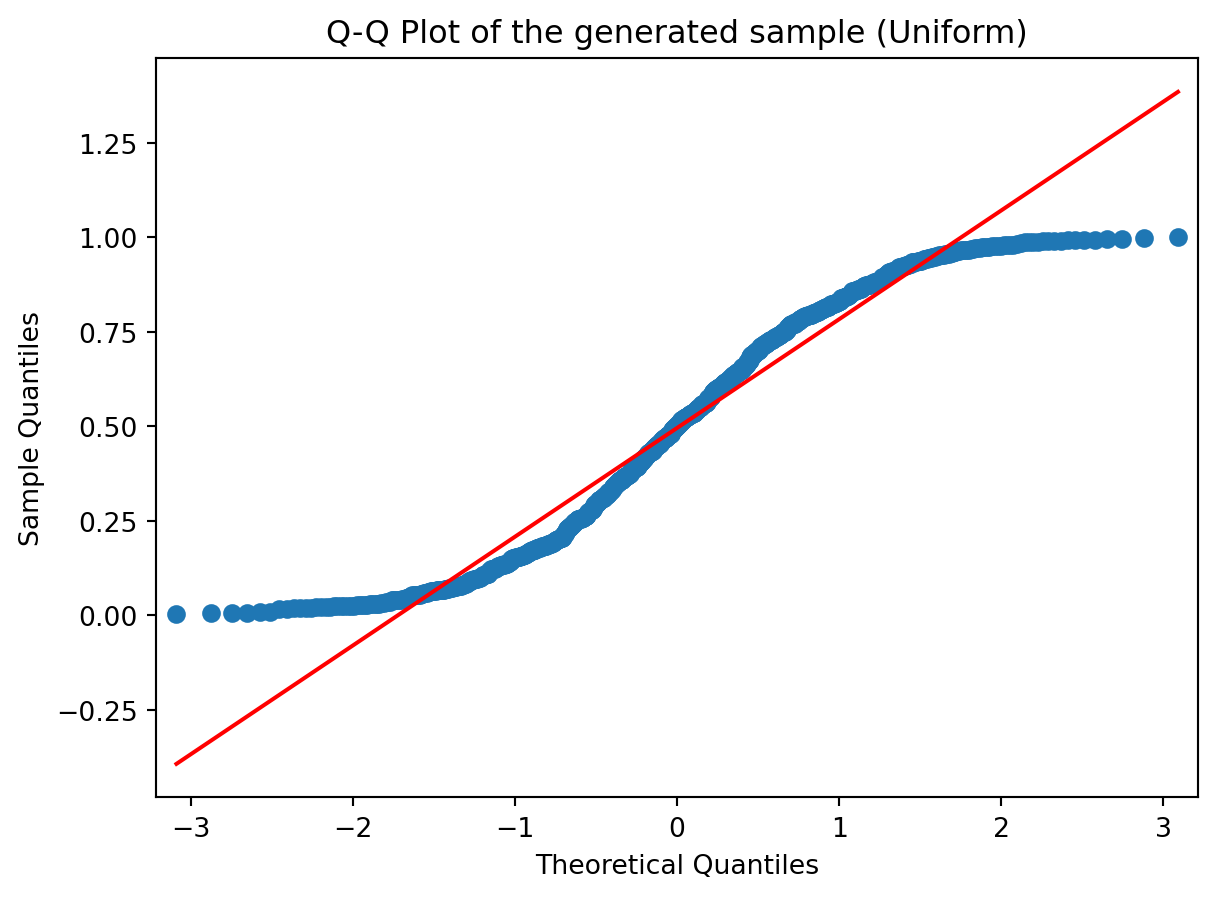

In [11]:
# Plotting the Q-Q Plot for our column
sm.qqplot(col, line='r')
plt.title('Q-Q Plot of the "{}" column of our dataset'.format(colname));

# Plotting the Q-Q Plot for the log of our column
sm.qqplot(np.log(col), line='r')
plt.title('Q-Q Plot of the Log of the "{}" column'.format(colname));

# Sampling from a Gaussian and a uniform distribution
sample_norm = np.random.randn(1000)
sample_unif = np.random.rand(1000)

# Plotting the second Q-Q Plot for our sample (that was generated using a normal distribution)
sm.qqplot(sample_norm, line='r')
plt.title('Q-Q Plot of the generated sample (Gaussian)')
sm.qqplot(sample_unif, line='r')
plt.title('Q-Q Plot of the generated sample (Uniform)');

<p>
    Go ahead and change the colname variable (question 1) into a different column name (that you can pick from the list you have just before question 1 (but do pick a numeric column). And re-execute the code from question 1 and question 2 and you'll see your new Q-Q plot of the column you just picked.
</p>

1) Have a look at the slides from Week 03 for different shapes

<p>
    Ok ? Now try to guess the shape of the distribution of our selected column (shape of its histogram) from its Q-Q Plot above.
</p>

1) Visualise the column on a histogram and reflect on whether the shape you inferred from Q-Q plots and the shape of the histogram correlate

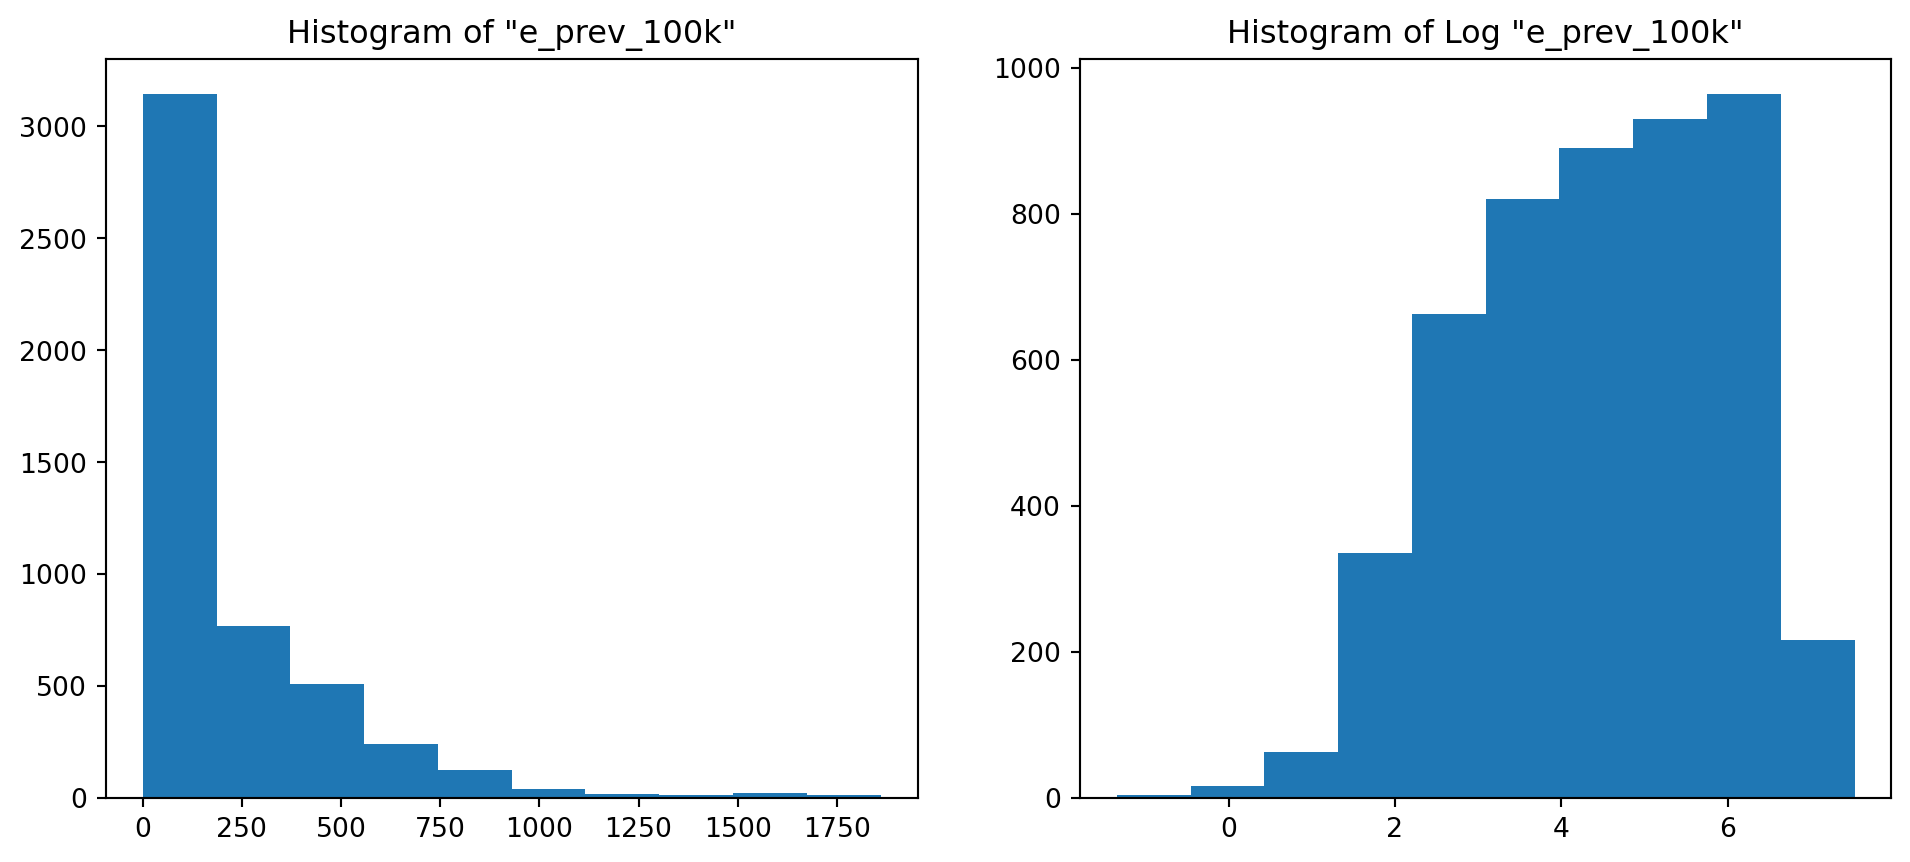

In [12]:
#| column: page-inset-right

# Histogramming the column we picked (not sure the verb exists though)
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title('Histogram of "{}"'.format(colname))
plt.hist(col)
plt.subplot(1,2,2)
plt.title('Histogram of Log "{}"'.format(colname))
plt.hist(np.log(col));

<p>
    Of course it does ! From the shape of the Q-Q Plot above (convex, slope upwards) and the Slide of Q-Q Plots from Week 3, we could conclude before looking at the histogram that our distribution was right tailed (or positively skewed if you're into complex vocabulary lol). And it is !
</p>

## Distributions, Sampling

1) Inspecting the effect of sample size on descriptive statistics

In [13]:
# Defining a few variables se we can change their values easiliy without having to change the rest of the code
n = [5, 20, 100, 2000]
stds = [0.5, 1, 3]

# Initializing empty 2D arrays where we're going to store the results of our simulation
mean = np.empty([len(n), len(stds)])
std = np.empty([len(n), len(stds)])
skewness = np.empty([len(n), len(stds)])
kurtos = np.empty([len(n), len(stds)])

# Conducting the experiments and storing the results in the respective 2D arrays
for i, sample_size in enumerate(n):
    for j, theoritical_std in enumerate(stds):
        sample = np.random.normal(loc=0, scale=theoritical_std, size=sample_size)
        mean[i,j] = sample.mean()
        std[i,j] = sample.std()
        skewness[i,j] = skew(sample)
        kurtos[i,j] = kurtosis(sample)

# Turning the mean 2D array into a pandas dataframe
mean = pd.DataFrame(mean, columns = stds, index = n)
mean = mean.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

# Turning the std 2D array into a pandas dataframe
std = pd.DataFrame(std, columns = stds, index = n)
std = std.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

# Turning the skewness 2D array into a pandas dataframe
skewness = pd.DataFrame(skewness, columns = stds, index = n)
skewness = skewness.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

# Turning the kurtosis 2D array into a pandas dataframe
kurtos = pd.DataFrame(kurtos, columns = stds, index = n)
kurtos = kurtos.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

print("GAUSSIAN DISTRIBUTION\n")
print('Results for the Mean :')
mean # This is a dataframe containing the means of the samples generated with different values of std and sample size
print('Results for the Standard Deviation :')
std # This is a dataframe containing the standard deviations of the samples generated with different values of std and sample size
print('Results for the Skewness :')
skewness # This is a dataframe containing the skews of the samples generated with different values of std and sample size
print('Results for the Kurtosis :')
kurtos # This is a dataframe containing the kurtosis of the samples generated with different values of std and sample size


GAUSSIAN DISTRIBUTION

Results for the Mean :
Results for the Standard Deviation :
Results for the Skewness :
Results for the Kurtosis :


Standard Deviation,0.5,1.0,3.0
Sample Size,,,
5,-0.678126,-1.167892,-0.715072
20,-0.804293,-1.139832,3.193534
100,-0.177612,-0.197195,-0.344788
2000,0.030172,0.011511,0.237727


<p>
    Basically, the more data you have (the bigger your sample), the more accurate your empirical estimates are going to be. Observe for example the values of mean (1st DataFrame) and variance (2nd DataFrame) for the 2000 sample size (last row). In the first one, the values are all close to 0, because we generated our sample from a Gaussian with mean 0, and the values in the second one are all close to the values in the column names (which refer to the variance of the distribution of the sample). This means that for with a sample size of 2000, our estimates are really close to the "True" values (with which we generated the sample). Also, the Skew of a Gaussian distribution should be 0, and it is confirmed in the 3rd DataFrame where the values are close to 0 in the last row (i.e big sample size).
</p>

<b>2) Same as before but with a Poisson distribution (which has just one parameter lambda instead of 2 like the gaussian)</b>

In [14]:
# Defining a few variables se we can change their values easiliy without having to change the rest of the code
n = [5, 20, 100, 2000]
lambd = [0.5, 1, 3] # In a gaussian we had two parameters, a var specified here and a mean we chose to be 0 
#everywhere. Here we have one parameter called lambda.

# Initializing empty 2D arrays where we're going to store the results of our simulation
mean = np.empty([len(n), len(lambd)])
std = np.empty([len(n), len(lambd)])
skewness = np.empty([len(n), len(lambd)])
kurtos = np.empty([len(n), len(lambd)])

# Conducting the experiments and storing the results in the respective 2D arrays
for i, sample_size in enumerate(n):
    for j, theoritical_lambd in enumerate(lambd):
        #**********************************************************************
        sample = np.random.poisson(lam = theoritical_lambd, size = sample_size) # THIS IS WHAT WE CHANGED IN Q2 !
        #**********************************************************************
        mean[i,j] = sample.mean()
        std[i,j] = sample.std()
        skewness[i,j] = skew(sample)
        kurtos[i,j] = kurtosis(sample)

# Turning the mean 2D array into a pandas dataframe
mean = pd.DataFrame(mean, columns = lambd, index = n)
mean = mean.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

# Turning the std 2D array into a pandas dataframe
std = pd.DataFrame(std, columns = lambd, index = n)
std = std.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

# Turning the skewness 2D array into a pandas dataframe
skewness = pd.DataFrame(skewness, columns = lambd, index = n)
skewness = skewness.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

# Turning the kurtosis 2D array into a pandas dataframe
kurtos = pd.DataFrame(kurtos, columns = lambd, index = n)
kurtos = kurtos.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

print("POISSON DISTRIBUTION\n")
print('Results for the Mean :')
mean # This is a dataframe containing the means of the samples generated with different values of std and sample size
print('Results for the Standard Deviation :')
std # This is a dataframe containing the standard deviations of the samples generated with different values of std 
#and sample size
print('Results for the Skewness :')
skewness # This is a dataframe containing the skews of the samples generated with different values of std and sample 
#size
print('Results for the Kurtosis :')
kurtos # This is a dataframe containing the kurtosis of the samples generated with different values of std and sample 
#size



POISSON DISTRIBUTION

Results for the Mean :
Results for the Standard Deviation :
Results for the Skewness :
Results for the Kurtosis :


Lambda,0.5,1.0,3.0
Sample Size,,,
5,-0.921875,-1.770321,-1.300000
20,-0.448980,-0.764524,-0.024282
100,1.423282,1.619597,-0.605165
2000,1.450237,1.469557,-0.163725


<p>
    Just remember, the lambda parameter that defines the Poisson distribution is also the mean of the distribution. This is confirmed in the first DataFrame where the values (means of samples) are close to the column labels (theoretical lambda which is also equal to theoretical mean), especially in the last row.
</p>

## Robust Statistics

1) Choose a number of columns with different shapes, for instance, "e_prev_100k_hi" is left skewed or some columns where the variation is high or you notice potential outliers. You can make use of a series of boxplots to exploratively analyse the data for outliers

In [15]:
# Listing the columns
df_tuber.columns

Index(['country', 'iso2', 'iso3', 'iso_numeric', 'g_whoregion', 'year',
       'e_pop_num', 'e_prev_100k', 'e_prev_100k_lo', 'e_prev_100k_hi',
       'e_prev_num', 'e_prev_num_lo', 'e_prev_num_hi', 'e_mort_exc_tbhiv_100k',
       'e_mort_exc_tbhiv_100k_lo', 'e_mort_exc_tbhiv_100k_hi',
       'e_mort_exc_tbhiv_num', 'e_mort_exc_tbhiv_num_lo',
       'e_mort_exc_tbhiv_num_hi', 'source_mort', 'e_inc_100k', 'e_inc_100k_lo',
       'e_inc_100k_hi', 'e_inc_num', 'e_inc_num_lo', 'e_inc_num_hi',
       'e_tbhiv_prct', 'e_tbhiv_prct_lo', 'e_tbhiv_prct_hi',
       'e_inc_tbhiv_100k', 'e_inc_tbhiv_100k_lo', 'e_inc_tbhiv_100k_hi',
       'e_inc_tbhiv_num', 'e_inc_tbhiv_num_lo', 'e_inc_tbhiv_num_hi',
       'source_tbhiv', 'c_cdr', 'c_cdr_lo', 'c_cdr_hi'],
      dtype='object')

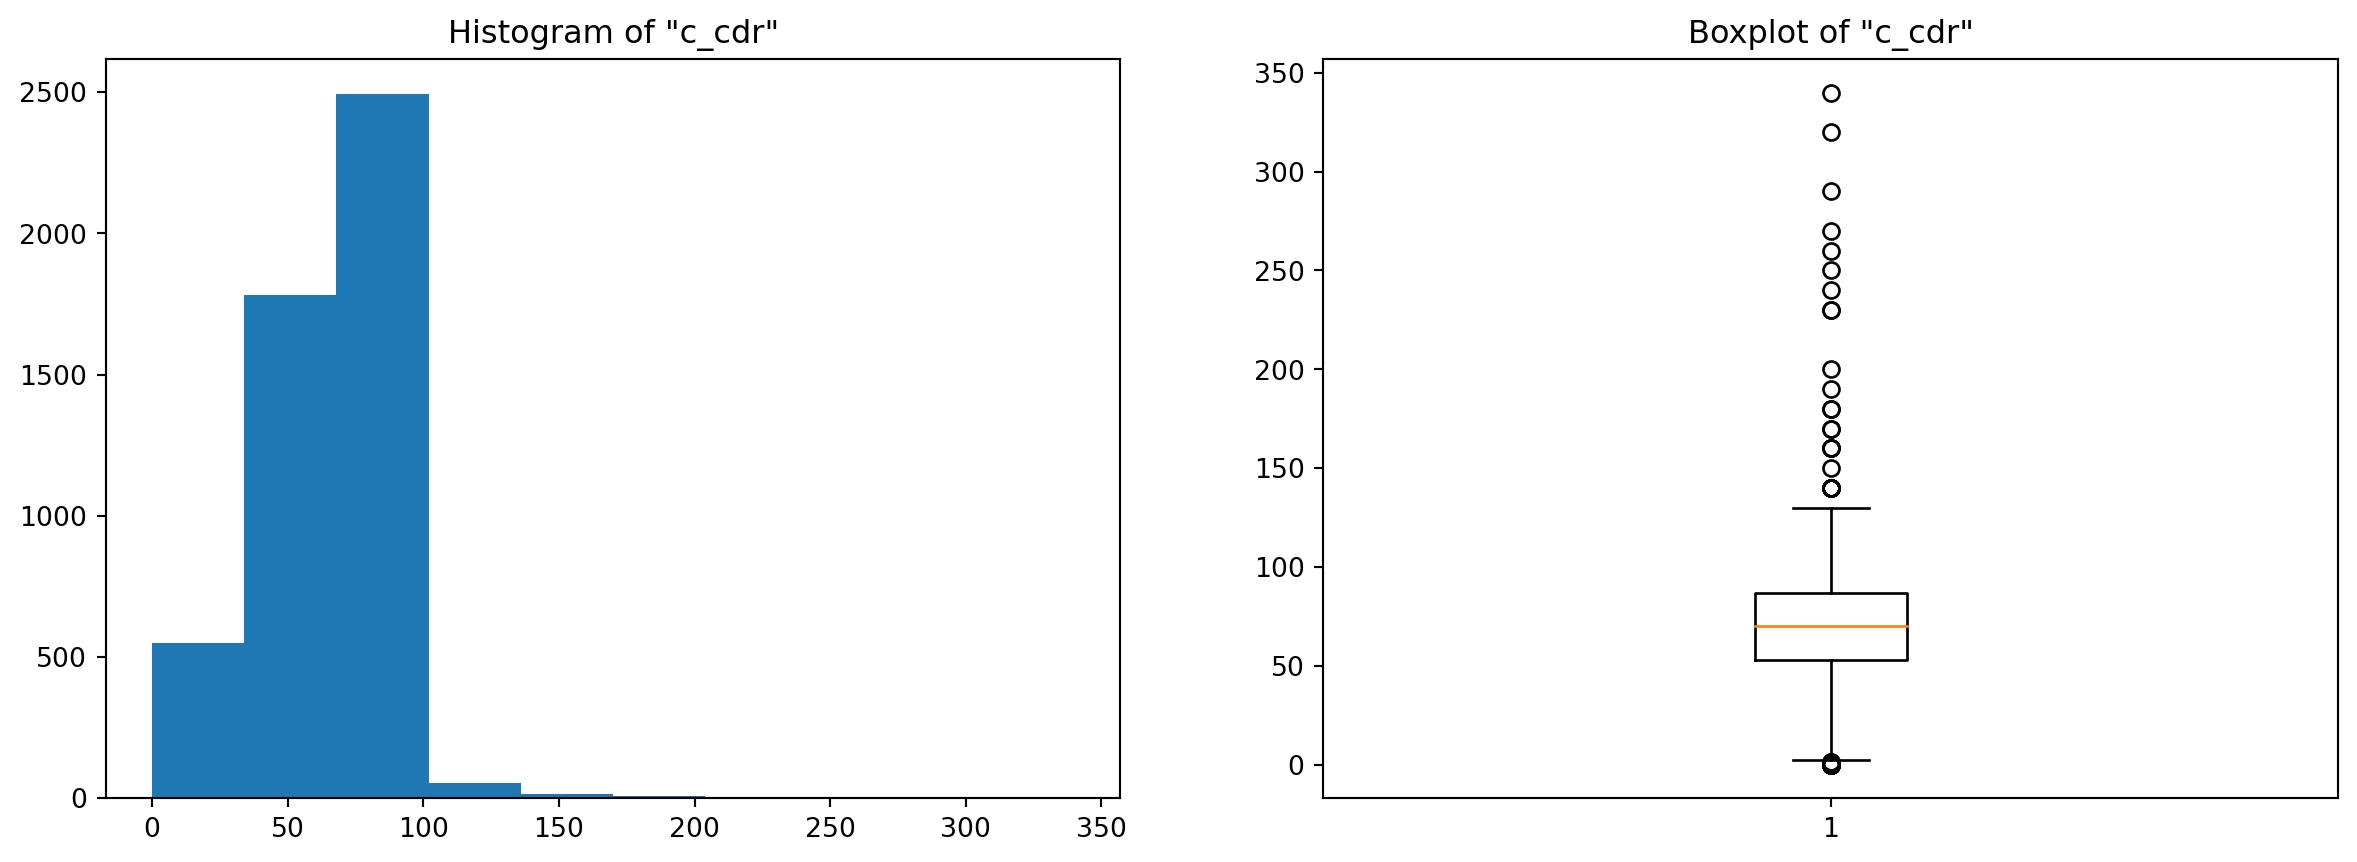

In [16]:
#| column: screen-inset

# Alright I already know a few columns with outliers but let's try to find them together exploratively using BoxPlots
colname = 'c_cdr' # change the column name by choosing different ones from above (numeric ones)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df_tuber[colname])
plt.title('Histogram of "{}"'.format(colname))
plt.subplot(1,2,2)
plt.boxplot(df_tuber[colname]);
plt.title('Boxplot of "{}"'.format(colname));

In [17]:
# Chosen columns : I picked 3, feel free to change them and experiment
chosen_colnames = ['e_pop_num', 'e_prev_100k', 'c_cdr']

<b>2) For the chosen columns, estimate both the conventional and the robust descriptive statistics and compare. Observe how these pairs deviate from each other based on the characteristics of the underlying data</b>

In [18]:
# Central Tendency : Mean vs Median (Median is the robust version of the mean, because it takes into account 
#the ordering of the points and not the actual values like the mean does)
df_tuber[chosen_colnames].describe().loc[['mean', '50%'], :] # The 50% is the median (50% quantile)

,e_pop_num,e_prev_100k,c_cdr
mean,2.899179e+07,207.694422,67.570706
50%,5.140332e+06,93.000000,70.000000


Look at how the values are different between the mean and the median ... LOOOOOOOK ! This is why when you have a skewed (unsymmetrical) distribution it's usually more interesting to use the median as a measure of the central tendency of the data. One important thing to note here, for the two first attributes, the mean is higher than the median, but for the last it's the opposite. This can tell you a thing or two about the shape of your distribution : if the mean is higher than the median, this means that the distribution is skewed to the right (right tail) which pulls the mean higher. And vice-versa.


Moral of the story is ... outliers are a pain in the a**. 

In [19]:
# Spread : Standard Deviation vs Inter-Quartile Range vs Median Absolute Deviation (MAD)
stds = df_tuber[chosen_colnames].std()
iqrs = df_tuber[chosen_colnames].quantile(0.75) - df_tuber[chosen_colnames].quantile(0.25)
medianAD = mad(df_tuber[chosen_colnames])

output = pd.DataFrame(stds, columns = ['std']).T
output = pd.concat([output, pd.DataFrame(iqrs, columns = ['IQR']).T], ignore_index=False)
output = pd.concat([output, pd.DataFrame(medianAD, columns = ['MAD'], index = chosen_colnames).T], ignore_index=False, names = ['std', 'iqr', 'mad'])
output

,e_pop_num,e_prev_100k,c_cdr
std,1.177827e+08,269.418159,25.234773
IQR,1.677193e+07,280.500000,34.000000
MAD,7.454908e+06,120.090780,25.204238


The values here are different as well, maybe more so for the "e_pop_num" attribute than the others, but that is just because of the scaling : "e_pop_num" takes big values overall compared to the other columns, which you can check with the mean values right above.

For the first attribute, the standard deviation is higher, and both the IQR and MAD are close to each other. For the second attribute, the inter-quartile range is slightly higher than the standard deviation, but the MAD is far below (less than half) the other two values, and the reason for that is a little bit involved : Basically, the standard deviation measures the spread by computing the squared deviation from the mean while the median absolute deviation evaluates the spread by computing the absolute deviation. This means that when the outliers have much bigger values than the "normal" points, the squared difference explodes (figuratively of course ;p) compared to the absolute difference. And this is actually the case for our second distribution (e_prev_100k) where most values are between 50 and 300 while many outliers lay above the 750 mark and go all the way up to 1800 (look at the boxplots below). For the third attribute the values are somewhat close, especially the std and the MAD, that's because if you inspect the boxplot, this column doesn't have many outliers to begin with.

Nonetheless, the differences are real, and if we don't want to have to handle outliers, then we should be using robust statistics like the median to describe the central tendency and inter-quartile range or median absolute deviation to measure the spread of our data.

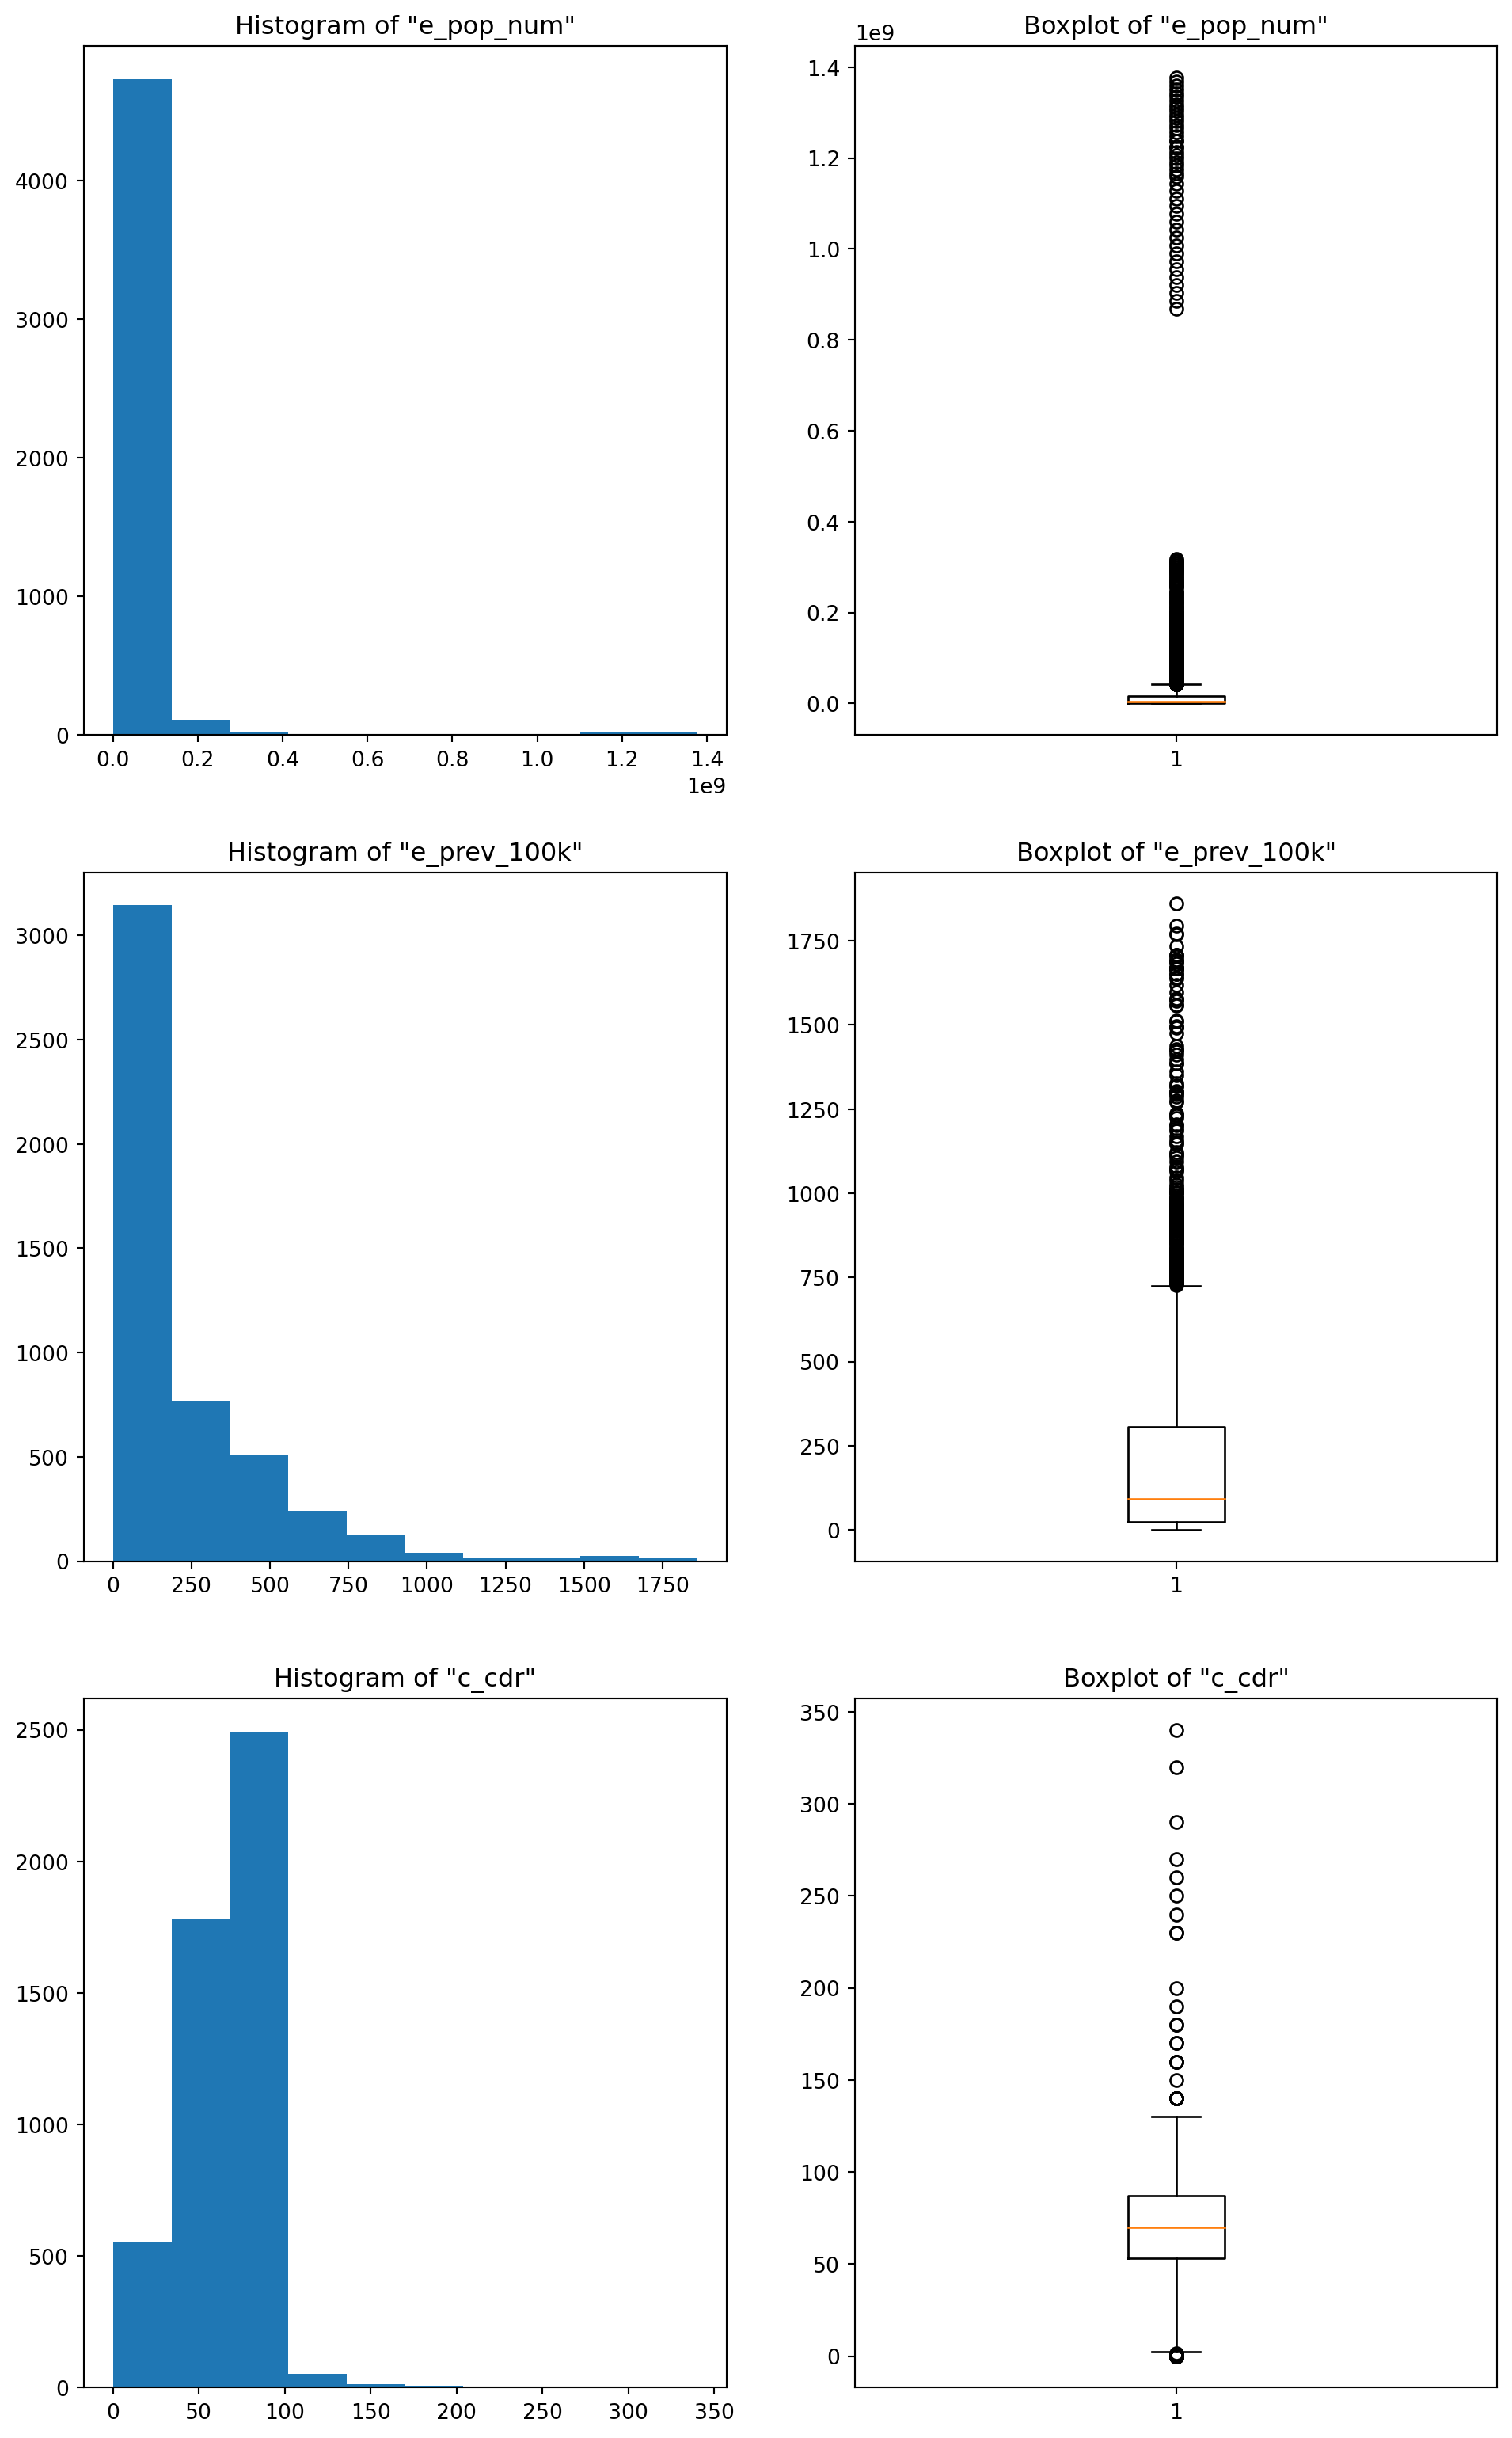

In [20]:
#| column: page-inset-right

# Boxplots of the different columns
plt.figure(figsize=(12,20))

plt.subplot(3,2,1)
plt.hist(df_tuber[chosen_colnames[0]])
plt.title('Histogram of "{}"'.format(chosen_colnames[0]))
plt.subplot(3,2,2)
plt.boxplot(df_tuber[chosen_colnames[0]])
plt.title('Boxplot of "{}"'.format(chosen_colnames[0]))

plt.subplot(3,2,3)
plt.hist(df_tuber[chosen_colnames[1]])
plt.title('Histogram of "{}"'.format(chosen_colnames[1]))
plt.subplot(3,2,4)
plt.boxplot(df_tuber[chosen_colnames[1]])
plt.title('Boxplot of "{}"'.format(chosen_colnames[1]))

plt.subplot(3,2,5)
plt.hist(df_tuber[chosen_colnames[2]])
plt.title('Histogram of "{}"'.format(chosen_colnames[2]))
plt.subplot(3,2,6)
plt.boxplot(df_tuber[chosen_colnames[2]])
plt.title('Boxplot of "{}"'.format(chosen_colnames[2]));